<a href="https://colab.research.google.com/github/IsisMaranhao/TCC_USPESALQ/blob/main/3_ARROZ_LICENSE_RESNET50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr 12 01:52:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    46W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Endereço - Kaglle dataset
# https://www.kaggle.com/datasets/alikhalilit98/rice-image-dataset-for-object-detection

In [ ]:
!pip install kaggle --upgrade
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from platform import python_version
print("Versão Python:", python_version())

Versão Python: 3.9.16


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"isismaranho","key":"2ed35c5c137ac60117f051206dbeccf2"}'}

In [ ]:
!mkdir -p ~/.kaggle
!echo > ~/.kaggle/kaggle.json
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d alikhalilit98/rice-image-dataset-for-object-detection

 97% 449M/462M [00:02<00:00, 186MB/s]
100% 462M/462M [00:02<00:00, 185MB/s]


In [ ]:
import zipfile
from google.colab import drive

zip_ref = zipfile.ZipFile("/content/rice-image-dataset-for-object-detection.zip", 'r')
zip_ref.extractall("/content/sample_data")
zip_ref.close()

In [ ]:
import numpy as np
import pandas as pd

import datetime
import timeit

import itertools
import glob
import cv2

import os
import os.path
from pathlib import Path

import seaborn as sns
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
from matplotlib import gridspec 
from google.colab.patches import cv2_imshow

import shutil

In [ ]:
import tensorflow as tf
from tensorflow import keras

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model

from keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Lambda
 
from keras.optimizers import Adam, SGD, RMSprop

from keras.applications import VGG16, ResNet50
from keras.applications.vgg16 import preprocess_input
from keras.utils import to_categorical, plot_model

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

VERIFICANDO SE AS IMAGENS ESTÃO NA PASTA CORRETAMENTE

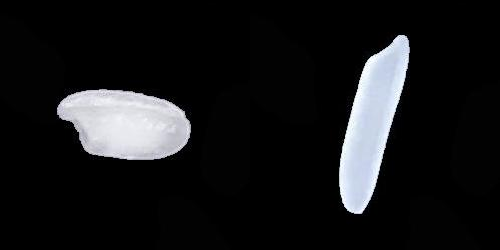

In [ ]:
img1=cv2.imread('/content/sample_data/Rice_Image_Dataset_OD/Arborio/Arborio (1).jpg')
img2=cv2.imread('/content/sample_data/Rice_Image_Dataset_OD/Basmati/Basmati (1).jpg')

final_image = cv2.hconcat((img1, img2))
 
cv2_imshow(final_image)

In [ ]:
# Verificando o tipo de dados da matriz da imagem
print('Dtype da imagem1 é {} e o Dtype da imagem2 é {} \n'
     .format(img1.dtype,img2.dtype))

# Verificando a altura da imagem
print('A altura da imagem1 é {} e a altura da imagem2 é {}'
     .format(img1.shape[0],img2.shape[0]))

# Verificando a largura da imagem
print('A largura da imagem1 é {} e a largura da imagem2 é {} \n'
     .format(img1.shape[1],img2.shape[1]))

# Verificando o número de canais da imagem
print('O número de canais da imagem1 é {} e o número de canais da imagem2 é {}'
     .format(img1.shape[2],img2.shape[2]))

Dtype da imagem1 é uint8 e o Dtype da imagem2 é uint8 

A altura da imagem1 é 250 e a altura da imagem2 é 250
A largura da imagem1 é 250 e a largura da imagem2 é 250 

O número de canais da imagem1 é 3 e o número de canais da imagem2 é 3


CRIANDO UMA PASTA COM NÚMEROS MENORES DE IMAGENS PARA APLICAR O MODELO

In [ ]:
diretorio = "/content/sample_data/"
nome_da_pasta = "Rice_Dataset_menor"

caminho_completo = os.path.join(diretorio, nome_da_pasta)
os.makedirs(caminho_completo, exist_ok=True)

In [ ]:
nomes_das_pastas=["Arborio","Basmati","Ipsala","Jasmine","Karacadag"]

for nome in nomes_das_pastas:
  diretorio = "/content/sample_data/Rice_Dataset_menor"
  caminho_completo = os.path.join(diretorio, nome)
  os.makedirs(caminho_completo, exist_ok=True)

In [ ]:
im_shape = (250,250)
seed = 10
BATCH_SIZE = 125 

nomes_das_pastas=["Arborio","Basmati","Ipsala","Jasmine","Karacadag"]

caminho_antigo="/content/sample_data/Rice_Image_Dataset_OD/"
caminho_novo="/content/sample_data/Rice_Dataset_menor/"

data = []

for pasta in nomes_das_pastas:
  src_folder = caminho_antigo + pasta
  dst_folder = caminho_novo + pasta

  # Obtenha a lista de todas as imagens .jpg na pasta de origem
  src_files = glob.glob(f"{src_folder}/*.jpg")[:750] # Quantidade de imagens por grupo

  # Move cada imagem para a pasta de destino
  for src_file in src_files:
    shutil.move(src_file, dst_folder)

    data_folder = os.listdir(dst_folder)
    data.extend(data_folder)

In [ ]:
arborio_images = []
basmati_images = []
ipsala_images = []
jasmine_images = []
karacadag_images = []

for img_path in glob.glob('/content/sample_data/Rice_Dataset_menor/Arborio/*.jpg'):
  arborio_images.append(mpimg.imread(img_path))

for img_path in glob.glob('/content/sample_data/Rice_Dataset_menor/Basmati/*.jpg'):
  basmati_images.append(mpimg.imread(img_path))

for img_path in glob.glob('/content/sample_data/Rice_Dataset_menor/Ipsala/*.jpg'):
  ipsala_images.append(mpimg.imread(img_path))

for img_path in glob.glob('/content/sample_data/Rice_Dataset_menor/Jasmine/*.jpg'):
  jasmine_images.append(mpimg.imread(img_path))
    
for img_path in glob.glob('/content/sample_data/Rice_Dataset_menor/Karacadag/*.jpg'):
  karacadag_images.append(mpimg.imread(img_path))

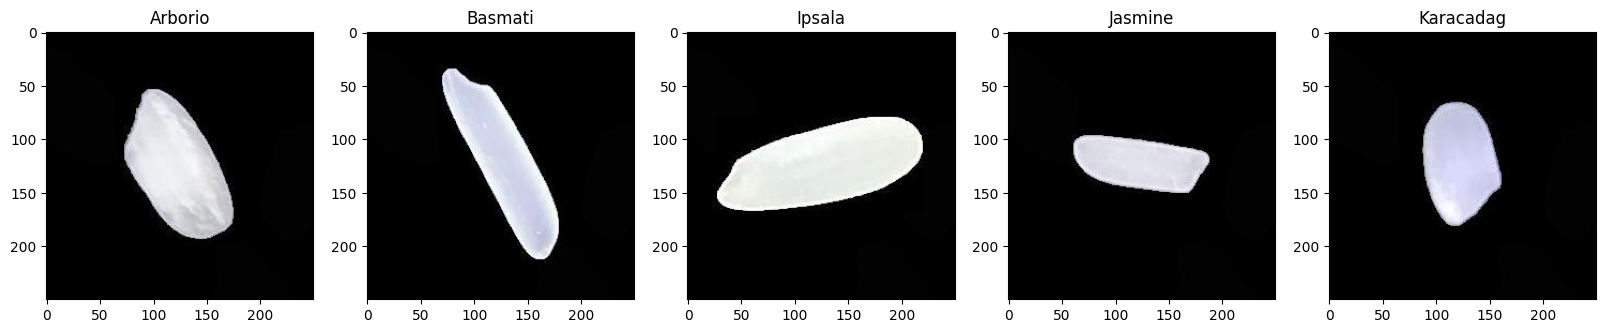

In [ ]:
fig, axs = plt.subplots(1,5, figsize=(20,20))

axs[0].imshow(arborio_images[1], cmap='gray')
axs[0].set_title('Arborio')

axs[1].imshow(basmati_images[1], cmap='gray')
axs[1].set_title('Basmati')

axs[2].imshow(ipsala_images[1], cmap='gray')
axs[2].set_title('Ipsala')

axs[3].imshow(jasmine_images[1], cmap='gray')
axs[3].set_title('Jasmine')

axs[4].imshow(karacadag_images[1], cmap='gray')
axs[4].set_title('Karacadag')

plt.show()

In [ ]:
print(len(arborio_images))
print(len(basmati_images))
print(len(ipsala_images))
print(len(jasmine_images))
print(len(karacadag_images))

750
750
750
750
750


In [ ]:
diretorio = "/content/sample_data/"
nome_da_pasta = "Rice_Dataset_menor"

caminho_completo = os.path.join(diretorio, nome_da_pasta)
os.makedirs(caminho_completo, exist_ok=True)

In [ ]:
data=caminho_completo

diretorio_completo = Path(caminho_completo)
caminhos_arquivos_png = list(diretorio_completo.glob("**/*.jpg"))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], caminhos_arquivos_png))

In [ ]:
print(len(labels))

3750


In [ ]:
# Caminhos & labels...
filepaths = pd.Series(caminhos_arquivos_png, name = 'File').astype(str)
labels = pd.Series(labels, name = 'Label')

# Concatenando...
df = pd.concat([filepaths, labels], axis=1)

# Mudando os nomes...
df['Label'].replace({"non_fire_images":"nofire","fire_images":"fire"}, inplace=True)

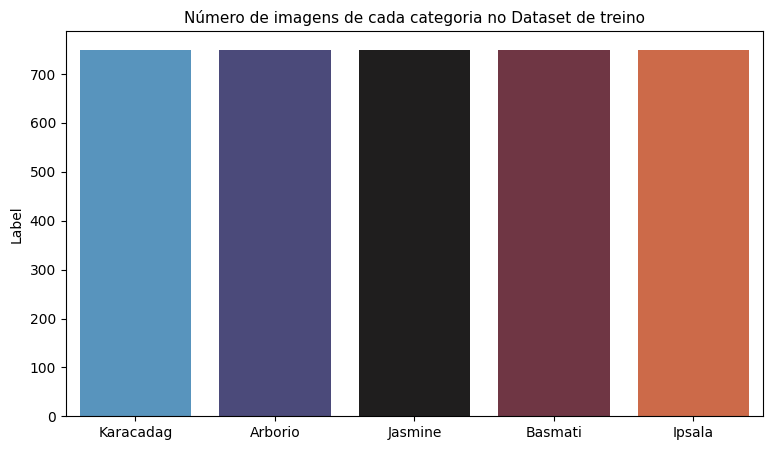

In [ ]:
# Visualizando os dados do dataset em um barplot
vc = df['Label'].value_counts()
plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index, y = vc, palette = "icefire")
plt.title("Número de imagens de cada categoria no Dataset de treino", fontsize = 11)
plt.savefig("/content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/3_RESNET50/grafico_quantidade_imagens_treino_RESNET50.jpg")
plt.show()

In [ ]:
print(vc.index[0])
print(vc.index[1])
print(vc.index[2])
print(vc.index[3])
print(vc.index[4])

Karacadag
Arborio
Jasmine
Basmati
Ipsala


CRIANDO BASE DE TREINO E VALIDAÇÃO

In [ ]:
# Misturando o dataframe e resetando o index
df = df.sample(frac = 1, random_state = 83).reset_index(drop = True)

# Resultado
df.head()

,File,Label
0,/content/sample_data/Rice_Dataset_menor/Karaca...,Karacadag
1,/content/sample_data/Rice_Dataset_menor/Karaca...,Karacadag
2,/content/sample_data/Rice_Dataset_menor/Arbori...,Arborio
3,/content/sample_data/Rice_Dataset_menor/Karaca...,Karacadag
4,/content/sample_data/Rice_Dataset_menor/Karaca...,Karacadag


In [ ]:
df_train, df_val = train_test_split(df, train_size = 0.7, random_state = 86)

df_train.head()
df_val.head()
print('Qtde de treino: {}'.format(len(df_train)))
print('Qtde de validaçao: {}'.format(len(df_val)))

Qtde de treino: 2625
Qtde de validaçao: 1125


In [ ]:
# Visualizando os dados em ambos datasets
print('Dataset de treinamento: \n')

print(f'Número de imagens: {df_train.shape[0]} \n')

print(f'Número de imagens Basmati: {df_train["Label"].value_counts()[0]}')
print(f'Número de imagens Jasmine: {df_train["Label"].value_counts()[1]}')
print(f'Número de imagens Karacadag: {df_train["Label"].value_counts()[2]}')
print(f'Número de imagens Arborio: {df_train["Label"].value_counts()[3]}')
print(f'Número de imagens Ipsala: {df_train["Label"].value_counts()[4]} \n')
      
print('Dataset de teste: \n')
      
print(f'Número de imagens no dataset de validacao: {df_val.shape[0]} \n')

print(f'Número de imagens Basmati: {df_val["Label"].value_counts()[0]}')
print(f'Número de imagens Jasmine: {df_val["Label"].value_counts()[1]}')
print(f'Número de imagens Karacadag: {df_val["Label"].value_counts()[2]}')
print(f'Número de imagens Arborio: {df_val["Label"].value_counts()[3]}')
print(f'Número de imagens Ipsala: {df_val["Label"].value_counts()[4]}')

Dataset de treinamento: 

Número de imagens: 2625 

Número de imagens Basmati: 534
Número de imagens Jasmine: 532
Número de imagens Karacadag: 527
Número de imagens Arborio: 520
Número de imagens Ipsala: 512 

Dataset de teste: 

Número de imagens no dataset de validacao: 1125 

Número de imagens Basmati: 238
Número de imagens Jasmine: 230
Número de imagens Karacadag: 223
Número de imagens Arborio: 218
Número de imagens Ipsala: 216


In [ ]:
#Separando x_train e y_train

y_train = df_train["Label"]
x_train = df_train.drop(labels = ["Label"],axis = 1)
print(x_train.head())

                                                   File
825   /content/sample_data/Rice_Dataset_menor/Jasmin...
1742  /content/sample_data/Rice_Dataset_menor/Arbori...
2484  /content/sample_data/Rice_Dataset_menor/Arbori...
2389  /content/sample_data/Rice_Dataset_menor/Karaca...
3036  /content/sample_data/Rice_Dataset_menor/Jasmin...


In [ ]:
x_train.shape

(2625, 1)

In [ ]:
# Separando x_val e y_val

y_val = df_val["Label"]
x_val = df_val.drop(labels = ["Label"],axis = 1)
print(x_val.head())

                                                   File
1182  /content/sample_data/Rice_Dataset_menor/Basmat...
1308  /content/sample_data/Rice_Dataset_menor/Basmat...
1390  /content/sample_data/Rice_Dataset_menor/Karaca...
2883  /content/sample_data/Rice_Dataset_menor/Ipsala...
1675  /content/sample_data/Rice_Dataset_menor/Ipsala...


In [ ]:
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(y_train)
Y_val = label_encoder.fit_transform(y_val)

In [ ]:
print(len(Y_train))
print(Y_train)

2625
[3 0 0 ... 1 4 3]


In [ ]:
print(len(Y_val))
print(Y_val)

1125
[1 1 4 ... 2 4 3]


Text(0.5, 1.0, 'Karacadag')

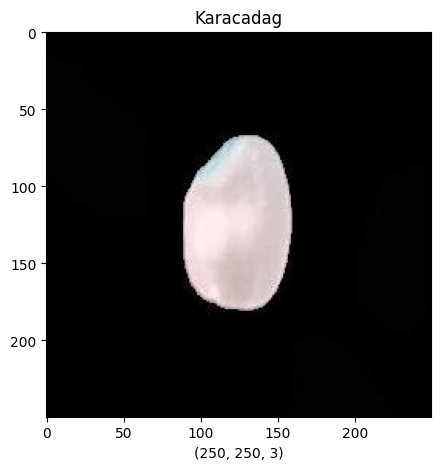

In [ ]:
# Observando as imagens do dataset de treino
figure = plt.figure(figsize=(5,5))
x = cv2.imread(df_train["File"][0])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df_train["Label"][0])

In [ ]:
data_generator = ImageDataGenerator(
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.3)

In [ ]:
# Generator para parte train
train_generator = data_generator.flow_from_directory(data, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generator para parte validação
validation_generator = val_data_generator.flow_from_directory(data, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generator para dataset de teste
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_generator.flow_from_directory(data, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())

print('Classes: '+str(classes))
num_classes  = len(classes)

Found 3000 images belonging to 5 classes.
Found 1125 images belonging to 5 classes.
Found 3750 images belonging to 5 classes.
Classes: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


ARQUITETURA RESNET50

In [ ]:
model3 = ResNet50(weights=None, include_top=False, input_shape=(250, 250, 3))

x = model3.output
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model3 = Model(inputs=model3.input, outputs=predictions)

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

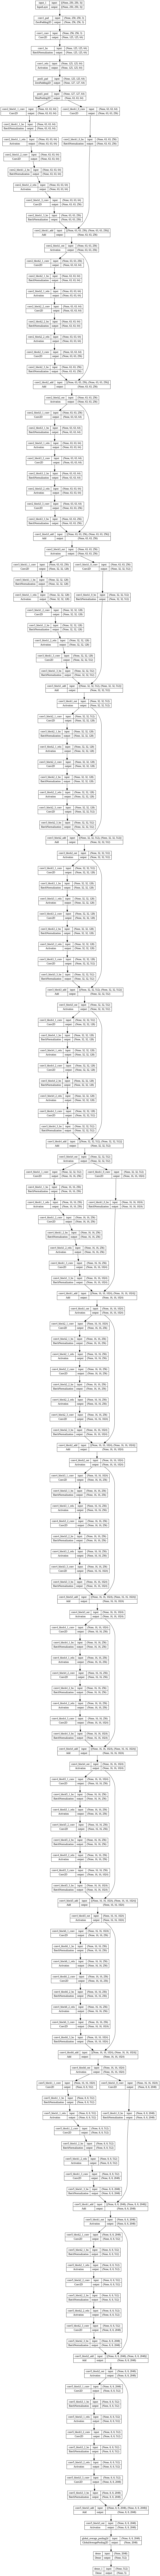

In [ ]:
plot_model(model3, to_file='model.png', show_layer_names = True , show_shapes = True)

In [ ]:
callback_1 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

caminho_de_arquivo = "/content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/3_RESNET50/"
callback_2 = keras.callbacks.ModelCheckpoint(caminho_de_arquivo, monitor='val_loss', verbose=1, patience=10, save_best_only=True, mode='min')

callback_3 = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, min_delta=0.1, patience=10, verbose=1)

In [ ]:
inicio = timeit.default_timer()

In [ ]:
epochs = 100

history3 = model3.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs = epochs,
    callbacks=[callback_1, callback_2, callback_3]
)

Epoch 1/100
24/24 [==============================] - ETA: 0s - loss: 2.1194 - accuracy: 0.4637
Epoch 1: val_loss improved from inf to 4616413.00000, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/3_RESNET50/


24/24 [==============================] - 122s 3s/step - loss: 2.1194 - accuracy: 0.4637 - val_loss: 4616413.0000 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - ETA: 0s - loss: 0.5190 - accuracy: 0.8063
Epoch 2: val_loss improved from 4616413.00000 to 62206.72656, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/3_RESNET50/


24/24 [==============================] - 68s 3s/step - loss: 0.5190 - accuracy: 0.8063 - val_loss: 62206.7266 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - ETA: 0s - loss: 0.3806 - accuracy: 0.8643
Epoch 3: val_loss improved from 62206.72656 to 857.16888, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/3_RESNET50/


24/24 [==============================] - 68s 3s/step - loss: 0.3806 - accuracy: 0.8643 - val_loss: 857.1689 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 4/100
24/24 [==============================] - ETA: 0s - loss: 0.2305 - accuracy: 0.9147
Epoch 4: val_loss improved from 857.16888 to 63.92862, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/3_RESNET50/


24/24 [==============================] - 68s 3s/step - loss: 0.2305 - accuracy: 0.9147 - val_loss: 63.9286 - val_accuracy: 0.2089 - lr: 0.0010
Epoch 5/100
24/24 [==============================] - ETA: 0s - loss: 0.2381 - accuracy: 0.9123
Epoch 5: val_loss did not improve from 63.92862
24/24 [==============================] - 43s 2s/step - loss: 0.2381 - accuracy: 0.9123 - val_loss: 70.6539 - val_accuracy: 0.2009 - lr: 0.0010
Epoch 6/100
24/24 [==============================] - ETA: 0s - loss: 0.1622 - accuracy: 0.9477
Epoch 6: val_loss improved from 63.92862 to 22.81701, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/3_RESNET50/


24/24 [==============================] - 68s 3s/step - loss: 0.1622 - accuracy: 0.9477 - val_loss: 22.8170 - val_accuracy: 0.2373 - lr: 0.0010
Epoch 7/100
24/24 [==============================] - ETA: 0s - loss: 0.2141 - accuracy: 0.9193
Epoch 7: val_loss improved from 22.81701 to 6.25495, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/3_RESNET50/


24/24 [==============================] - 68s 3s/step - loss: 0.2141 - accuracy: 0.9193 - val_loss: 6.2549 - val_accuracy: 0.2996 - lr: 0.0010
Epoch 8/100
24/24 [==============================] - ETA: 0s - loss: 0.1407 - accuracy: 0.9487
Epoch 8: val_loss did not improve from 6.25495
24/24 [==============================] - 43s 2s/step - loss: 0.1407 - accuracy: 0.9487 - val_loss: 6.9739 - val_accuracy: 0.2800 - lr: 0.0010
Epoch 9/100
24/24 [==============================] - ETA: 0s - loss: 0.1304 - accuracy: 0.9563
Epoch 9: val_loss did not improve from 6.25495
24/24 [==============================] - 43s 2s/step - loss: 0.1304 - accuracy: 0.9563 - val_loss: 8.8147 - val_accuracy: 0.2240 - lr: 0.0010
Epoch 10/100
24/24 [==============================] - ETA: 0s - loss: 0.1375 - accuracy: 0.9503
Epoch 10: val_loss improved from 6.25495 to 1.44793, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/3_RESNET50/


24/24 [==============================] - 68s 3s/step - loss: 0.1375 - accuracy: 0.9503 - val_loss: 1.4479 - val_accuracy: 0.5716 - lr: 0.0010
Epoch 11/100
24/24 [==============================] - ETA: 0s - loss: 0.1568 - accuracy: 0.9403
Epoch 11: val_loss did not improve from 1.44793
24/24 [==============================] - 43s 2s/step - loss: 0.1568 - accuracy: 0.9403 - val_loss: 7.3469 - val_accuracy: 0.3476 - lr: 0.0010
Epoch 12/100
24/24 [==============================] - ETA: 0s - loss: 0.1409 - accuracy: 0.9537
Epoch 12: val_loss did not improve from 1.44793
24/24 [==============================] - 43s 2s/step - loss: 0.1409 - accuracy: 0.9537 - val_loss: 14.5576 - val_accuracy: 0.2702 - lr: 0.0010
Epoch 13/100
24/24 [==============================] - ETA: 0s - loss: 0.0972 - accuracy: 0.9653
Epoch 13: val_loss did not improve from 1.44793
24/24 [==============================] - 43s 2s/step - loss: 0.0972 - accuracy: 0.9653 - val_loss: 15.8630 - val_accuracy: 0.3458 - lr: 0.001

24/24 [==============================] - 68s 3s/step - loss: 0.1041 - accuracy: 0.9627 - val_loss: 0.5328 - val_accuracy: 0.8738 - lr: 0.0010
Epoch 17/100
24/24 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.9750
Epoch 17: val_loss improved from 0.53279 to 0.50072, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/3_RESNET50/


24/24 [==============================] - 68s 3s/step - loss: 0.0694 - accuracy: 0.9750 - val_loss: 0.5007 - val_accuracy: 0.8169 - lr: 0.0010
Epoch 18/100
24/24 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 0.9763
Epoch 18: val_loss did not improve from 0.50072
24/24 [==============================] - 43s 2s/step - loss: 0.0593 - accuracy: 0.9763 - val_loss: 0.5945 - val_accuracy: 0.7511 - lr: 0.0010
Epoch 19/100
24/24 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9787
Epoch 19: val_loss improved from 0.50072 to 0.15632, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/3_RESNET50/


24/24 [==============================] - 67s 3s/step - loss: 0.0610 - accuracy: 0.9787 - val_loss: 0.1563 - val_accuracy: 0.9369 - lr: 0.0010
Epoch 20/100
24/24 [==============================] - ETA: 0s - loss: 0.0646 - accuracy: 0.9767
Epoch 20: val_loss did not improve from 0.15632
24/24 [==============================] - 43s 2s/step - loss: 0.0646 - accuracy: 0.9767 - val_loss: 2.9880 - val_accuracy: 0.5876 - lr: 0.0010
Epoch 21/100
24/24 [==============================] - ETA: 0s - loss: 0.0839 - accuracy: 0.9753
Epoch 21: val_loss did not improve from 0.15632
24/24 [==============================] - 43s 2s/step - loss: 0.0839 - accuracy: 0.9753 - val_loss: 8.7416 - val_accuracy: 0.4658 - lr: 0.0010
Epoch 22/100
24/24 [==============================] - ETA: 0s - loss: 0.0487 - accuracy: 0.9840
Epoch 22: val_loss did not improve from 0.15632
24/24 [==============================] - 43s 2s/step - loss: 0.0487 - accuracy: 0.9840 - val_loss: 1.3621 - val_accuracy: 0.7298 - lr: 0.0010


In [ ]:
fim = timeit.default_timer()

In [ ]:
duracao_segundos = fim - inicio
duracao_formatada = str(datetime.timedelta(seconds=duracao_segundos))
inicio_formatado = datetime.datetime.fromtimestamp(inicio).strftime('%Y-%m-%d %H:%M:%S.%f')
fim_formatado = datetime.datetime.fromtimestamp(fim).strftime('%Y-%m-%d %H:%M:%S.%f')

print('Duração:', duracao_formatada)

Duração: 0:25:50.027767


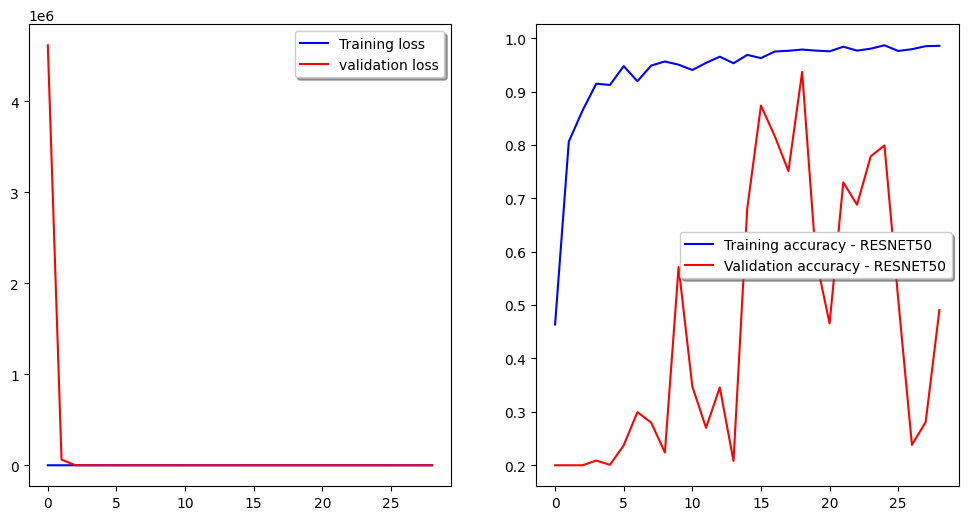

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(history3.history['loss'], color='b', label="Training loss")from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')
  print('You are using a high-RAM runtime!')
ax[0].plot(history3.history['val_loss'], color='r', label="validation loss",axes =ax[0])

legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history3.history['accuracy'], color='b', label="Training accuracy - RESNET50")
ax[1].plot(history3.history['val_accuracy'], color='r',label="Validation accuracy - RESNET50")

legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
score3 = model3.evaluate(validation_generator)
print("Test Accuracy:", score3[1])
print("Test Loss:", score3[0])

9/9 [==============================] - 4s 400ms/step - loss: 3.1004 - accuracy: 0.4907
Test Accuracy: 0.4906666576862335
Test Loss: 3.1004323959350586


In [ ]:
score_train3=model3.evaluate(train_generator)
print("Train Accuracy:", score_train3[1])
print("Train Loss:", score_train3[0])

24/24 [==============================] - 40s 2s/step - loss: 3.0437 - accuracy: 0.5327
Train Accuracy: 0.5326666831970215
Train Loss: 3.043731212615967


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("/content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/3_RESNET50/Confution_Matrix_RESNET50.jpg")

30/30 [==============================] - 10s 310ms/step
Classification Report - RESNET50
              precision    recall  f1-score   support

     Arborio       1.00      0.01      0.01       750
     Basmati       0.39      1.00      0.56       750
      Ipsala       1.00      0.32      0.48       750
     Jasmine       0.87      0.10      0.18       750
   Karacadag       0.51      1.00      0.67       750

    accuracy                           0.49      3750
   macro avg       0.75      0.49      0.38      3750
weighted avg       0.75      0.49      0.38      3750



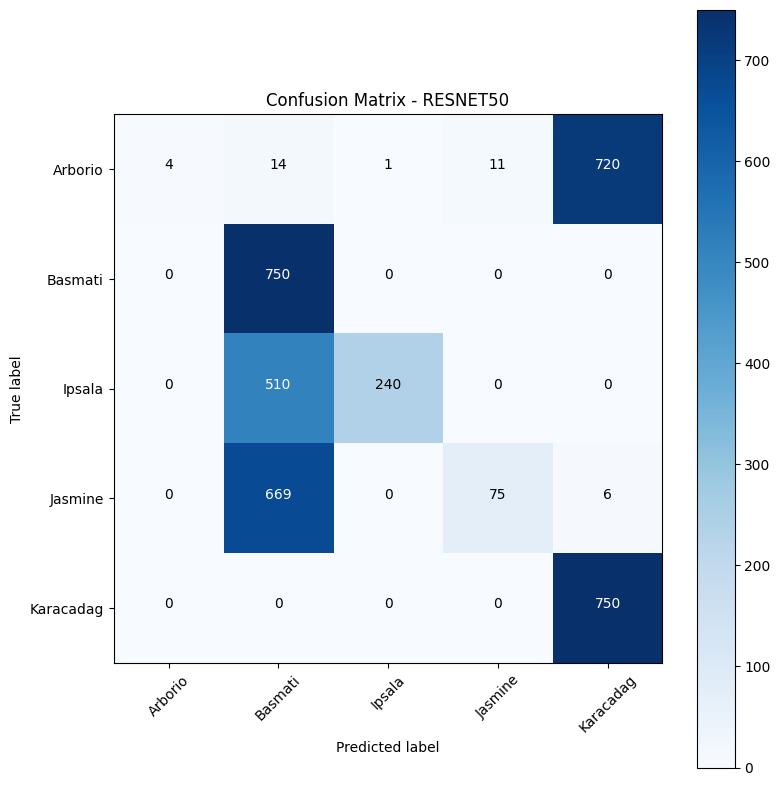

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model3.predict(test_generator, steps=nb_test_samples // BATCH_SIZE, workers=1)

y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix - RESNET50')

print('Classification Report - RESNET50')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))